# Pipelines subpackage

The `opr.pipelines` subpackage contains ready-to-use pipelines for model inference. In this tutorial we will examine how to build database and utilize`opr.pipelines.localization.ArucoLocalizationPipeline`.

## Imports & functions

In [1]:
from time import time

import cv2
from hydra.utils import instantiate
import numpy as np
from omegaconf import OmegaConf
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from geotransformer.utils.registration import compute_registration_error
from geotransformer.utils.pointcloud import get_transform_from_rotation_translation

from opr.datasets.itlp import ITLPCampus
from opr.pipelines.localization import ArucoLocalizationPipeline
from opr.pipelines.place_recognition import PlaceRecognitionPipeline
from opr.pipelines.registration import PointcloudRegistrationPipeline


def pose_to_matrix(pose):
    """From the 6D poses in the [tx ty tz qx qy qz qw] format to 4x4 pose matrices."""
    position = pose[:3]
    orientation_quat = pose[3:]
    rotation = Rotation.from_quat(orientation_quat)
    pose_matrix = np.eye(4)
    pose_matrix[:3,:3] = rotation.as_matrix()
    pose_matrix[:3,3] = position
    return pose_matrix

def compute_error(estimated_pose, gt_pose):
    """For the 6D poses in the [tx ty tz qx qy qz qw] format."""
    estimated_pose = pose_to_matrix(estimated_pose)
    gt_pose = pose_to_matrix(gt_pose)
    error_pose = np.linalg.inv(estimated_pose) @ gt_pose
    dist_error = np.sum(error_pose[:3, 3]**2) ** 0.5
    r = Rotation.from_matrix(error_pose[:3, :3])
    rotvec = r.as_rotvec()
    angle_error = (np.sum(rotvec**2)**0.5) * 180 / np.pi
    angle_error = abs(90 - abs(angle_error-90))
    return dist_error, angle_error

def compute_translation_error(gt_pose, pred_pose):
    """For the 4x4 pose matrices."""
    gt_trans = gt_pose[:3, 3]
    pred_trans = pred_pose[:3, 3]
    error = np.linalg.norm(gt_trans - pred_trans)
    return error

def compute_rotation_error(gt_pose, pred_pose):
    """For the 4x4 pose matrices."""
    gt_rot = Rotation.from_matrix(gt_pose[:3, :3])
    pred_rot = Rotation.from_matrix(pred_pose[:3, :3])
    error = Rotation.inv(gt_rot) * pred_rot
    error = error.as_euler('xyz', degrees=True)
    error = np.linalg.norm(error)
    return error

def compute_absolute_pose_error(gt_pose, pred_pose):
    """For the 4x4 pose matrices."""
    rotation_error = compute_rotation_error(gt_pose, pred_pose)
    translation_error = compute_translation_error(gt_pose, pred_pose)
    return rotation_error, translation_error

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Usage example - ArucoLocalizationPipeline

#### Weights download

You can download the `minkloc3d_nclt.pth` from the HuggingFace model hub:
https://huggingface.co/OPR-Project/PlaceRecognition-NCLT.

```bash
wget -O ../weights/place_recognition/minkloc3d_nclt.pth https://huggingface.co/OPR-Project/PlaceRecognition-NCLT/resolve/main/minkloc3d_nclt.pth
```

#### Dataset download

You can download the dataset:

- Kaggle:
  - [ITLP Campus Indoor](https://www.kaggle.com/datasets/alexandermelekhin/itlp-campus-indoor)
- Hugging Face:
  - [ITLP Campus Indoor](https://huggingface.co/datasets/OPR-Project/ITLP-Campus-Indoor)


#### How to build the database

The minimum requirement to initialize the `PlaceRecognitionPipeline` is that the database directory should contain the `index.faiss` file and the `track.csv` file.

The `index.faiss` file is a Faiss index, which contains the descriptors of the database. The `track.csv` file contains the metadata of the database, including the id and the pose of the descriptors.

The details on how to create the database are described in the [build_database.ipynb](./build_database.ipynb) notebook.

**Please update** the `DATABASE_TRACK_DIR` variable in the `build_database.ipynb` notebook to be the same as the `DATABASE_TRACK_DIR` variable in this notebook.

Note that the actual data are not required, as the pipeline will only load the `index.faiss` and the `track.csv` file. This can be useful in the real-world scenario, where the database size is too large to be stored on the local machine.

In [2]:
DATABASE_DIR = "/home/docker_opr/Datasets/OpenPlaceRecognition/itlp_campus_indoor/00_2023-10-25-night/floor_1"
DATABASE_TRACK_DIR = "/home/docker_opr/Datasets/OpenPlaceRecognition/itlp_campus_indoor/00_2023-10-25-night/floor_1"
QUERY_TRACK_DIR = "/home/docker_opr/Datasets/OpenPlaceRecognition/itlp_campus_indoor/01_2023-11-09-twilight/floor_1"

DEVICE = "cuda"

MODEL_CONFIG_PATH = "../configs/model/place_recognition/minkloc3d.yaml"
WEIGHTS_PATH = "../weights/place_recognition/minkloc3d_nclt.pth"

In [3]:
query_dataset = ITLPCampus(
    dataset_root=QUERY_TRACK_DIR,
    sensors=["lidar", "front_cam", "back_cam"],
    mink_quantization_size=0.5,
    load_semantics=False,
    load_text_descriptions=False,
    load_text_labels=False,
    load_aruco_labels=False,
    indoor=False,
    image_transform=lambda x: x,
)

In [4]:
query_dataset[0].keys()

dict_keys(['idx', 'pose', 'image_front_cam', 'image_back_cam', 'pointcloud_lidar_coords', 'pointcloud_lidar_feats'])

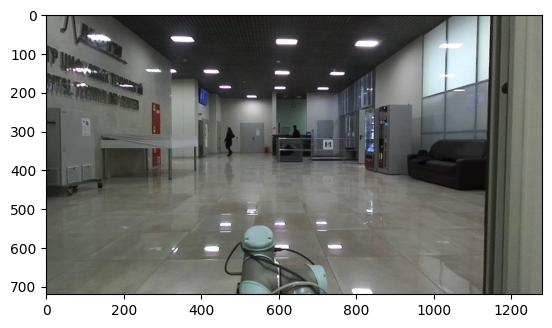

In [5]:
plt.imshow(query_dataset[0]["image_front_cam"])

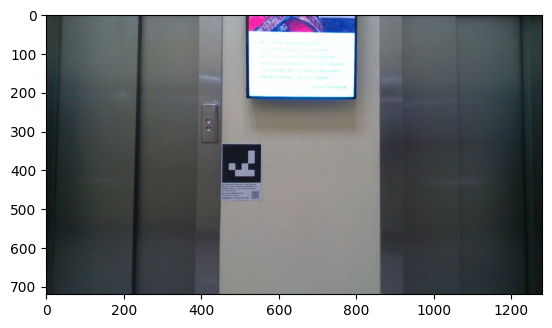

In [6]:
plt.imshow(query_dataset[0]["image_back_cam"])

In [7]:
model_config = OmegaConf.load(MODEL_CONFIG_PATH)
model = instantiate(model_config)

2025-05-06 14:11:34.157 | WARNING  | opr.models.place_recognition.pointmamba:<module>:16 - The 'pointmamba' package is not installed. Please install it manually if neccessary.


In [8]:
pipe = PlaceRecognitionPipeline(
    database_dir=DATABASE_DIR,
    model=model,
    model_weights_path=WEIGHTS_PATH,
    device=DEVICE,
)

In [9]:
REGISTRATION_MODEL_CONFIG_PATH = "../configs/model/registration/geotransformer_kitti.yaml"
REGISTRATION_WEIGHTS_PATH = "../weights/registration/geotransformer_kitti.pth"

geotransformer = instantiate(OmegaConf.load(REGISTRATION_MODEL_CONFIG_PATH))

registration_pipe = PointcloudRegistrationPipeline(
    model=geotransformer,
    model_weights_path=REGISTRATION_WEIGHTS_PATH,
    device="cuda",  # the GeoTransformer currently only supports CUDA
    voxel_downsample_size=0.3,  # recommended for geotransformer_kitti configuration
)

In [10]:
### TF tree: world (localization frame) -> baselink (often is a robot "center") -> sensor (camera frame) -> aruco frame
### Place recognition model return baselink2world transformation.
### In our ArucoLocalizationPipeline we use sensor2baselink precalculated calibaration to find transformation between encoded in marker aruco pose
### (in world frame) to robot current baselink.

camera_metadata = {
    "front_cam_intrinsics": [[683.6199340820312, 0.0, 615.1160278320312],
                             [0.0, 683.6199340820312, 345.32354736328125],
                             [0.0, 0.0, 1.0]],
    "front_cam_distortion": [0.0, 0.0, 0.0, 0.0, 0.0],
    "front_cam2baselink": [-0.2388, 0.06, 0.75, -0.5, 0.49999999999755174, -0.5, 0.5000000000024483],
    "back_cam_intrinsics": [[910.4178466796875, 0.0, 648.44140625],
                            [0.0, 910.4166870117188, 354.0118408203125],
                            [0.0, 0.0, 1.0]],
    "back_cam_distortion": [0.0, 0.0, 0.0, 0.0, 0.0],
    "back_cam2baselink": [-0.3700594606670597, -0.006647301538708517, 0.7427924789987381, -0.4981412857230513, -0.4907829006275322, 0.5090864815669471, 0.5018149813673275]
}

In [11]:
aruco_metadata = {
    "aruco_type": cv2.aruco.DICT_4X4_250,
    "aruco_size": 0.2,
    "aruco_gt_pose_by_id": {
        11: [-1.82410266, -0.08805033, 1.0027102, 0.52255674, 0.54868202, 0.46970398, 0.45305703],
        12: [-1.89103056, -0.16381068, 100.68857262, 0.5104185, 0.48182796, 0.47396991, 0.53166464],
        13: [-1.65826485, -0.23034471, 200.85429952, 0.53442465, 0.45258975, 0.45886568, 0.54680444],
        14: [-1.97089803, -0.128250737, 300.867689, 0.42405458, 0.59517182, 0.56236239, 0.38690667],
        15: [-1.50259591, -0.0313240790, 400.699101, 0.45946361, 0.4809916,  0.50211729, 0.55264681]
    }
}

In [12]:
database = ITLPCampus(
    dataset_root=DATABASE_TRACK_DIR,
    sensors=["lidar", "front_cam", "back_cam"],
    mink_quantization_size=0.5,
    load_semantics=False,
    load_text_descriptions=False,
    load_text_labels=False,
    load_aruco_labels=False,
    indoor=False,
    image_transform=lambda x: x,
)

pipe = ArucoLocalizationPipeline(
    place_recognition_pipeline=pipe,
    registration_pipeline=registration_pipe,
    pointclouds_subdir="lidar",
    aruco_metadata=aruco_metadata,
    camera_metadata=camera_metadata
)

In [13]:
sample_data = query_dataset[0]
sample_pose_gt = sample_data.pop("pose")  # removing those keys are not necessary, we just
sample_data.pop("idx")                    # want to simulate that we pass the data without GT information :)
print(f"sample_data.keys() = {sample_data.keys()}")
sample_output = pipe.infer(sample_data)
print(f"sample_output.keys() = {sample_output.keys()}")

print("---")
print(f"sample_output['pose_by_aruco'] = {sample_output['pose_by_aruco']}")
print(f"sample_output['pose_by_place_recognition'] = {sample_output['pose_by_place_recognition']}")
print(f"pose_gt = {sample_pose_gt.numpy()}")
dist_error, angle_error = compute_error(sample_output['pose_by_aruco'], sample_pose_gt.numpy())
print(f"dist_error = {dist_error}, angle_error = {angle_error}")

sample_data.keys() = dict_keys(['image_front_cam', 'image_back_cam', 'pointcloud_lidar_coords', 'pointcloud_lidar_feats'])
Detect Aruco with id [11] on image_back_cam
Utilize Aruco with id [11] on image_back_cam for pose estimation due min distanse
sample_output.keys() = dict_keys(['pose_by_aruco', 'pose_by_place_recognition'])
---
sample_output['pose_by_aruco'] = [ 0.22555389  0.30522212 -0.1077821   0.00266913  0.08967084  0.02035835
  0.99575979]
sample_output['pose_by_place_recognition'] = None
pose_gt = [ 0.33936495  0.01101168  0.0344989   0.00360157  0.00187057 -0.00173084
  0.9999903 ]
dist_error = 0.3460586991184888, angle_error = 10.3901231485887


In [14]:
import warnings
warnings.filterwarnings("ignore")

PR_MATCH_THRESHOLD = 25.0
pr_matches = []
rre_list = []
rte_list = []
times = []

for i, sample in enumerate(query_dataset):
    print(f"--- frame_{i} ---")
    gt_pose = sample.pop("pose")
    gt_pose = get_transform_from_rotation_translation(Rotation.from_quat(gt_pose[3:]).as_matrix(), gt_pose[:3])

    start_time = time()
    pipe_out = pipe.infer(sample)
    times.append(time() - start_time)

    estimated_pose = pipe_out["pose_by_aruco"] if pipe_out["pose_by_aruco"] is not None else pipe_out["pose_by_place_recognition"]
    estimated_pose = get_transform_from_rotation_translation(Rotation.from_quat(estimated_pose[3:]).as_matrix(), estimated_pose[:3])

    _, db_match_distance = compute_registration_error(gt_pose, estimated_pose)
    pr_matched = db_match_distance <= PR_MATCH_THRESHOLD
    pr_matches.append(pr_matched)

    rre, rte = compute_registration_error(gt_pose, estimated_pose)
    rre_list.append(rre)
    rte_list.append(rte)

--- frame_0 ---
Detect Aruco with id [11] on image_back_cam
Utilize Aruco with id [11] on image_back_cam for pose estimation due min distanse
--- frame_1 ---
Detect Aruco with id [11] on image_back_cam
Utilize Aruco with id [11] on image_back_cam for pose estimation due min distanse
--- frame_2 ---
--- frame_3 ---
--- frame_4 ---
--- frame_5 ---
--- frame_6 ---
--- frame_7 ---
--- frame_8 ---
--- frame_9 ---
--- frame_10 ---
--- frame_11 ---
--- frame_12 ---
--- frame_13 ---
--- frame_14 ---
--- frame_15 ---
--- frame_16 ---
--- frame_17 ---
--- frame_18 ---
--- frame_19 ---
--- frame_20 ---
--- frame_21 ---
--- frame_22 ---
--- frame_23 ---
--- frame_24 ---
--- frame_25 ---
--- frame_26 ---
--- frame_27 ---
--- frame_28 ---
--- frame_29 ---
--- frame_30 ---
--- frame_31 ---
--- frame_32 ---
--- frame_33 ---
--- frame_34 ---
--- frame_35 ---
--- frame_36 ---
--- frame_37 ---
--- frame_38 ---
--- frame_39 ---
--- frame_40 ---
--- frame_41 ---
--- frame_42 ---
--- frame_43 ---
--- frame_

In [15]:
print(f"ArucoPlaceRecognition R@1 = {np.mean(pr_matches):0.3f}")
print(f"ArucoLocalization Mean RRE = {np.mean(rre_list):0.3f}")
print(f"ArucoLocalization Mean RTE = {np.mean(rte_list):0.3f}")

print(f"ArucoLocalization Median RRE = {np.median(rre_list):0.3f}")
print(f"ArucoLocalization Median RTE = {np.median(rte_list):0.3f}")

print(f"Mean Time = {(np.mean(times) * 1000):0.2f} ms")

ArucoPlaceRecognition R@1 = 0.916
ArucoLocalization Mean RRE = 54.906
ArucoLocalization Mean RTE = 7.637
ArucoLocalization Median RRE = 10.992
ArucoLocalization Median RTE = 2.251
Mean Time = 388.44 ms
